# **학습목표**

* 카리나, 마동석, 이국주

In [ ]:
# 폰트 설치
!apt -qq -y install fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# **Setting**

In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/메타버스 아카데미/Data/')
import warnings
warnings.filterwarnings('ignore')                       # warning 출력 false

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import koreanize_matplotlib

plt.rcParams['font.family'] = 'NanumGothic'
# plt.rc('font', family='NanumGothic')            # matplotllib
mpl.rcParams['axes.unicode_minus'] = False      # minus 처리

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam

from torchvision.datasets.cifar import CIFAR10
from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize, ToTensor, Resize

# **1. 데이터 수집하기**

* 파일 저장 계획

```
- train
    ㄴ 카리나
    ㄴ 마동석
    ㄴ 이국주
- test
    ㄴ 카리나
    ㄴ 마동석
    ㄴ 이국주
```

In [ ]:
# Bing으로 이미지 다운로드 하는 github 복제하기
!git clone https://github.com/ndb796/bing_image_downloader

Cloning into 'bing_image_downloader'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 86 (delta 17), reused 10 (delta 10), pack-reused 64
Unpacking objects: 100% (86/86), 17.48 KiB | 18.00 KiB/s, done.


In [ ]:
# 이미지 저장할 폴더 만들기
directory_list = ['train/','test/']

for dir in directory_list:
    dir_path = './celebrity/' + dir
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)

In [ ]:
# 데이터 수집하기
import os
import shutil
from bing_image_downloader.bing_image_downloader import downloader

celebrity_list = ['카리나','마동석','이국주']
for celebrity in celebrity_list:
    downloader.download(celebrity, limit=50, output_dir='./celebrity', adult_filter_off=True, force_replace=False, timeout=60)

[Info] Indexing page: 1
[Info] Indexed 36 Images on Page 1.
#1 이미지 다운로드 (https://img.sbs.co.kr/newsnet/etv/upload/2020/10/28/30000654805_1280.jpg)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://dimg.donga.com/wps/SPORTS/IMAGE/2014/03/31/62131499.4.jpg)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://img.hankyung.com/photo/202112/03.28304862.1.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://dbkpop.com/wp-content/uploads/2021/05/aespa_next_level_teaser_karina_1.jpg)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://preview.redd.it/38kvenwgbdm81.jpg?auto=webp&amp;s=58f518d6a8353c6ae2f095e88016b38a2c76cb7f)
[Info] Issue getting: https://preview.redd.it/38kvenwgbdm81.jpg?auto=webp&amp;s=58f518d6a8353c6ae2f095e88016b38a2c76cb7f
[Error] HTTP Error 403: Forbidden
#5 이미지 다운로드 (https://coolhdwall.com/storage/202106/karina-aespa-savage-4K-wallpaper-pc-preview.jpg)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://1.bp.blogspot.com/-VoBtn_s7dhE/YIyXs-50BeI/AAAAAAACIW0/5hETmFRB20Q_BykEMN8a9XLPQOpYi_zfQCLcBGAsYHQ/s0/pic_003.pn

In [ ]:
# 이미지 train, test 나누기
def images_split(query, train_cnt):
    directory_list = ['train/','test/']

    for dir in directory_list:
        dir_path = './celebrity/' + dir + query
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)

    # 사진 저장
    cnt = 0
    curr_path = './celebrity/' + query
    for file_name in os.listdir(curr_path):
        if cnt < train_cnt:
            print(f'train data : {file_name}')
            move_path = './celebrity/train/' + query
            shutil.move(curr_path + '/' + file_name, move_path)
        else:
            print(f'test data : {file_name}')
            move_path = './celebrity/test/' + query
            shutil.move(curr_path + '/' + file_name, move_path)

        cnt += 1

    shutil.rmtree(curr_path)

In [ ]:
celebrity_list = ['카리나','마동석','이국주']

for celebrity in celebrity_list:
    images_split(celebrity, 40)

# **2. 데이터 불러오기 및 전처리**

In [2]:
train_transforms = Compose(
    [
        Resize((224,224)),
        RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        Normalize(mean=(0.485, 0.456, 0.406),std=(0.229,0.224,0.225))
    ]
)

test_transforms = Compose(
    [
        Resize((224,224)),
        T.ToTensor(),
        Normalize(mean=(0.485, 0.456, 0.406),std=(0.229,0.224,0.225))
    ]
)

In [3]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root = './celebrity/train',transform = train_transforms)
test_data = ImageFolder(root = './celebrity/test',transform = test_transforms)

In [4]:
print(f'train_data = {len(train_data)}   train_target = {len(test_data)}')

train_data = 119   train_target = 29


In [5]:
# data loader
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [6]:
data, label = next(iter(train_loader))

In [7]:
print(f'train_data = {data.shape}   label_data = {label.shape}')

train_data = torch.Size([4, 3, 224, 224])   label_data = torch.Size([4])


In [8]:
from torchvision.utils import make_grid

def imshow(img, title):
    print(img.numpy().shape)
    img = img.numpy().transpose((1,2,0))

    mean = [0.485, 0.456, 0.406]
    std = [0.229,0.224,0.225]

    img = mean + img * std
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.show()

In [9]:
class_names = train_data.classes
print('클래스:', class_names)

클래스: ['마동석', '이국주', '카리나']


(3, 228, 906)


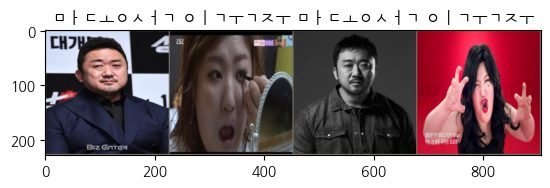

In [11]:
iter_ = iter(train_loader)

data, labels = next(iter_)
out = make_grid(data)

imshow(out, title=f"{str(' '.join([class_names[x] for x in labels]))}")

# **3. 모델 설정**

In [12]:
# gpu 쓸 수 있는지 check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [24]:
from torchvision.models import resnet34

model = resnet34(pretrained=True)      # 가중치를 업데이트 할 수 있다
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# 가중치 freeze
for param in model.parameters():
    param.requires_grad = False

In [26]:
# (classifier) 층 바꾸기
num_features = model.fc.in_features

model.fc = nn.Linear(in_features=num_features, out_features=3)

# model gpu로 보내기
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
for name, module in model.named_parameters():
    print(name, module.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer2.2.conv1.weight False
layer2.2.bn1.weight False
layer2.2.bn1

# **4. 모델 학습하기**

In [28]:
import tqdm

optim = Adam(model.parameters(), lr=1e-4)
epochs = 30

for epoch in range(epochs):
    for data, label in tqdm.tqdm(train_loader):
        optim.zero_grad()

        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = nn.CrossEntropyLoss()(output, label)
        loss.backward()

        optim.step()

    print(f'epoch = {epoch + 1}, loss = {loss.item()}')


100%|██████████| 30/30 [00:02<00:00, 10.38it/s]


epoch = 1, loss = 1.1596390008926392


100%|██████████| 30/30 [00:02<00:00, 13.36it/s]


epoch = 2, loss = 0.9611704349517822


100%|██████████| 30/30 [00:02<00:00, 13.33it/s]


epoch = 3, loss = 0.9996712803840637


100%|██████████| 30/30 [00:02<00:00, 10.07it/s]


epoch = 4, loss = 0.9361132979393005


100%|██████████| 30/30 [00:03<00:00,  9.68it/s]


epoch = 5, loss = 1.0708824396133423


100%|██████████| 30/30 [00:02<00:00, 10.21it/s]


epoch = 6, loss = 1.0140032768249512


100%|██████████| 30/30 [00:02<00:00, 13.37it/s]


epoch = 7, loss = 0.7899167537689209


100%|██████████| 30/30 [00:02<00:00, 13.44it/s]


epoch = 8, loss = 1.2754169702529907


100%|██████████| 30/30 [00:02<00:00, 13.41it/s]


epoch = 9, loss = 1.0145403146743774


100%|██████████| 30/30 [00:02<00:00, 13.52it/s]


epoch = 10, loss = 0.9644710421562195


100%|██████████| 30/30 [00:02<00:00, 10.03it/s]


epoch = 11, loss = 0.9122042059898376


100%|██████████| 30/30 [00:02<00:00, 11.56it/s]


epoch = 12, loss = 0.4693247377872467


100%|██████████| 30/30 [00:02<00:00, 13.58it/s]


epoch = 13, loss = 1.0511716604232788


100%|██████████| 30/30 [00:02<00:00, 13.53it/s]


epoch = 14, loss = 0.7846217155456543


100%|██████████| 30/30 [00:02<00:00, 13.43it/s]


epoch = 15, loss = 0.6451420783996582


100%|██████████| 30/30 [00:02<00:00, 12.30it/s]


epoch = 16, loss = 1.0342570543289185


100%|██████████| 30/30 [00:03<00:00,  9.38it/s]


epoch = 17, loss = 1.3738282918930054


100%|██████████| 30/30 [00:02<00:00, 13.00it/s]


epoch = 18, loss = 1.1663199663162231


100%|██████████| 30/30 [00:02<00:00, 13.44it/s]


epoch = 19, loss = 0.8465344309806824


100%|██████████| 30/30 [00:02<00:00, 13.12it/s]


epoch = 20, loss = 0.6633066534996033


100%|██████████| 30/30 [00:02<00:00, 13.42it/s]


epoch = 21, loss = 0.7264739871025085


100%|██████████| 30/30 [00:02<00:00, 10.73it/s]


epoch = 22, loss = 0.7797569632530212


100%|██████████| 30/30 [00:02<00:00, 10.82it/s]


epoch = 23, loss = 0.6169204115867615


100%|██████████| 30/30 [00:02<00:00, 13.22it/s]


epoch = 24, loss = 0.6519402861595154


100%|██████████| 30/30 [00:02<00:00, 13.60it/s]


epoch = 25, loss = 0.9806601405143738


100%|██████████| 30/30 [00:02<00:00, 13.68it/s]


epoch = 26, loss = 0.5923425555229187


100%|██████████| 30/30 [00:02<00:00, 13.75it/s]


epoch = 27, loss = 0.6504701972007751


100%|██████████| 30/30 [00:03<00:00,  9.65it/s]


epoch = 28, loss = 0.777027428150177


100%|██████████| 30/30 [00:02<00:00, 12.33it/s]


epoch = 29, loss = 0.46789050102233887


100%|██████████| 30/30 [00:02<00:00, 13.25it/s]

epoch = 30, loss = 0.8353676199913025


In [29]:
# 모델 저장
save_path = './models/'
torch.save(model, save_path + 'celebrity.pth')

# 모델 가중치 저장
# torch.save(model.state_dict(), 'celebrity_state_dict.pt')

In [ ]:
# 모델 불러오기
save_path = './models/'
model = torch.load(save_path + 'celebrity.pth')

# model gpu로 보내기
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **5. 모델 예측**

In [30]:
model.eval()        # dropout, batch normalize 적용안되게 함.

pred_list = []
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        _, pred = torch.max(preds.data, 1)
        pred_list.extend(pred)

        corr = pred.eq(labels).sum().item()
        total_corr += corr
        print(corr, end=' ')

    print()
    print(f'Accuracy = {total_corr / len(test_data)}')

4 4 4 4 4 3 3 1 
Accuracy = 0.9310344827586207


In [ ]:
test_data.imgs

[('./celebrity/test/마동석/image_41.jpg', 0),
 ('./celebrity/test/마동석/image_42.jpg', 0),
 ('./celebrity/test/마동석/image_43.jpg', 0),
 ('./celebrity/test/마동석/image_44.jpg', 0),
 ('./celebrity/test/마동석/image_45.png', 0),
 ('./celebrity/test/마동석/image_46.jpeg', 0),
 ('./celebrity/test/마동석/image_47.jpg', 0),
 ('./celebrity/test/마동석/image_48.jpg', 0),
 ('./celebrity/test/마동석/image_49.jpg', 0),
 ('./celebrity/test/마동석/image_50.jpg', 0),
 ('./celebrity/test/이국주/image_41.jpg', 1),
 ('./celebrity/test/이국주/image_42.jpg', 1),
 ('./celebrity/test/이국주/image_43.jpg', 1),
 ('./celebrity/test/이국주/image_44.jpg', 1),
 ('./celebrity/test/이국주/image_45.jpg', 1),
 ('./celebrity/test/이국주/image_46.jpg', 1),
 ('./celebrity/test/이국주/image_47.jpg', 1),
 ('./celebrity/test/이국주/image_48.jpg', 1),
 ('./celebrity/test/이국주/image_49.jpg', 1),
 ('./celebrity/test/이국주/image_50.jpg', 1),
 ('./celebrity/test/카리나/image_41.JPG', 2),
 ('

In [ ]:
class_names

['마동석', '이국주', '카리나']

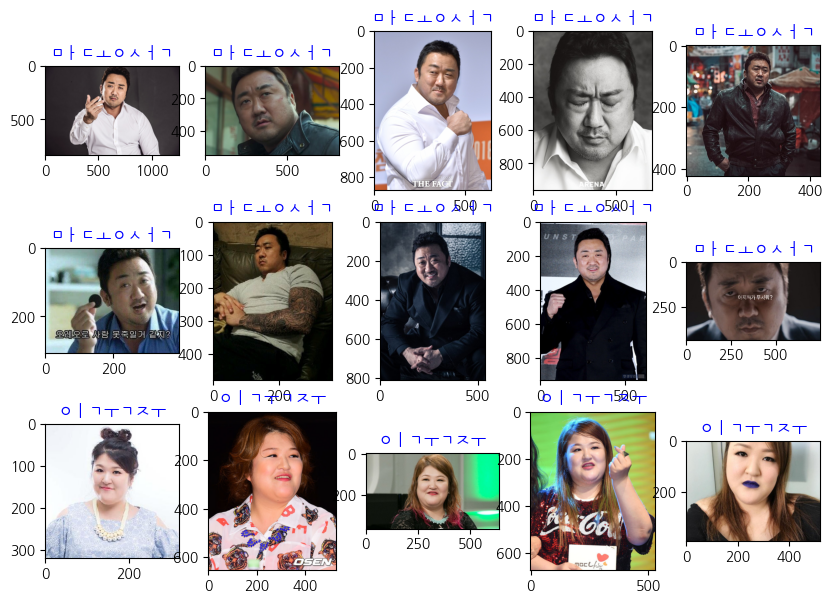

In [31]:
from PIL import Image

class_names = train_data.classes

fig = plt.figure(figsize=(10, 7))
for i, (path, y) in enumerate(test_data.imgs):
    # X = X.numpy().transpose((1,2,0))
    ax = plt.subplot(3, 5, i+1)
    yhat = pred_list[i]
    if y == yhat:
        color = 'blue'
        title = class_names[y]
    else:
        color = 'red'
        title = f'{class_names[y]}({class_names[yhat]})'

    X = np.array(Image.open(path))
    ax.imshow(X)
    ax.set_title(title, color=color)

    if i+1 == 15:
        break